In [1]:
import numpy as np

from constants import ENTITY_NAME, PROJECT_FULL_KRR, PROJECT_INDUCING_KRR 
from constants import FONTSIZE, USE_LATEX, LEGEND_SPECS, OPT_LABELS, OPT_COLORS, DUMMY_PLOTTING_RANK
from constants import PERFORMANCE_DATASETS_CLASSIFICATION_CFG, PERFORMANCE_DATASETS_REGRESSION_CFG
from base_utils import set_fontsize, render_in_latex, _get_clean_data, get_x, get_color
from cfg_utils import create_krr_config, _get_filtered_runs

import matplotlib.pyplot as plt

In [ ]:
set_fontsize(FONTSIZE)
if USE_LATEX:
    render_in_latex()

In [ ]:
CLASSIFICATION_EPS = 1e-3
REGRESSION_REL_EPS = 1e-2

In [ ]:
ASKOTCH_FILTER = {
    "optimizer": lambda run: run.config["opt"] == "askotchv2",
    "accelerated": lambda run: run.config["accelerated"],
    "preconditioned": lambda run: run.config["precond_params"] is not None,
    "rho_damped": lambda run: run.config.get("precond_params", {}).get("rho", None)
    == "damped",
    "sampling": lambda run: run.config["sampling_method"] == "uniform",
    "block_sz_frac": lambda run: run.config["block_sz_frac"] == 0.01,
    "finished": lambda run: run.state == "finished",
}
EIGENPRO2_FILTER = {
    "optimizer": lambda run: run.config["opt"] == "eigenpro2",
    "finished": lambda run: run.state == "finished",
}
EIGENPRO3_FILTER = {
    "optimizer": lambda run: run.config["opt"] == "eigenpro3",
    "finished": lambda run: run.state == "finished",
}
PCG_FLOAT64_FILTER = {
    "optimizer": lambda run: run.config["opt"] == "pcg",
    "precision": lambda run: run.config["precision"] == "float64",
    "not_greedy_cholesky_or_falkon": lambda run: not (
        run.config["precond_params"]["type"] == "partial_cholesky"
        and run.config["precond_params"]["mode"] == "greedy"
    ) and not run.config["precond_params"]["type"] == "falkon",
    "finished": lambda run: run.state == "finished",
}
FALKON_FLOAT64_FILTER = {
    "optimizer": lambda run: run.config["opt"] == "pcg",
    "precision": lambda run: run.config["precision"] == "float64",
    "falkon": lambda run: run.config["precond_params"]["type"] == "falkon",
    "finished": lambda run: run.state == "finished",
}

In [4]:
filters = {
    "askotchv2": ASKOTCH_FILTER,
    "eigenpro2": EIGENPRO2_FILTER,
    "eigenpro3": EIGENPRO3_FILTER,
    "pcg": PCG_FLOAT64_FILTER,
    "falkon": FALKON_FLOAT64_FILTER,
}

krr_configs = {}
for key, value in filters.items():
    if key in ["eigenpro3", "falkon"]:
        krr_configs[key] = create_krr_config(proj_name=PROJECT_INDUCING_KRR, base_criteria=[value])
    else:
        krr_configs[key] = create_krr_config(proj_name=PROJECT_FULL_KRR, base_criteria=[value])

In [5]:
def get_krr_runs(dataset_cfgs, krr_configs):
    krr_runs = {}
    for dataset_cfg in dataset_cfgs:
        for ds in dataset_cfg["datasets"].keys():
            krr_runs[ds] = {}
            krr_runs[ds]["runs"] = {}
            krr_runs[ds]["metric"] = dataset_cfg["datasets"][ds]["metric"]
            for key, value in krr_configs.items():
                krr_runs[ds]["runs"][key] = _get_filtered_runs(value, ds, ENTITY_NAME)
    return krr_runs

In [6]:
def get_peak_metric(run, metric):
    y, _ = _get_clean_data(run, metric)
    if metric == "test_acc":
        return y.max()
    else:
        return y.min()

In [7]:
def get_best_metric_val(krr_runs_dataset):
    metric = krr_runs_dataset["metric"]
    best_metric_val = 0 if metric == "test_acc" else np.inf
    for key, value in krr_runs_dataset["runs"].items():
        for run in value:
            peak_metric = get_peak_metric(run, metric)
            # print(f"{run.id}: {peak_metric}")

            if metric == "test_acc":
                best_metric_val = max(best_metric_val, peak_metric)
            else:
                best_metric_val = min(best_metric_val, peak_metric)
    return best_metric_val

In [ ]:
def get_stopping_point(run, metric, best_val):
    y, steps = _get_clean_data(run, metric)
    times = get_x(run, steps, "time")
    if metric == "test_acc":
        eps = CLASSIFICATION_EPS
        relative = False
    else:
        eps = REGRESSION_REL_EPS
        relative = True

    if relative:
        condition = y <= best_val * (1 + eps)
    else:
        condition = y >= best_val - eps

    indices = np.where(condition)[0]
    if indices.size > 0:
        return times[indices[0]]
    return np.inf

    # # Go through y (enumerating) and find the first point where the metric is within eps of the best_val
    # for i, val in enumerate(y):
    #     if relative:
    #         if val <= best_val * (1 + eps):
    #             return times[i]
    #     else:
    #         if val >= best_val - eps:
    #             return times[i]
    # return np.inf

In [9]:
def convert_time_to_frac(time, run):
    return time / run.config["max_time"]

In [10]:
def get_best_stopping_points(krr_runs_dataset, best_metric_val_dataset):
    metric = krr_runs_dataset["metric"]
    best_stopping_points = {}
    for key, value in krr_runs_dataset["runs"].items():
        best_stopping_point = np.inf
        for run in value:
            stopping_point = get_stopping_point(run, metric, best_metric_val_dataset)
            # print(f"{run.id}: {stopping_point}")

            best_stopping_point = min(best_stopping_point, stopping_point)
        # Implicitly assumes all runs for the same optimizer have the same time budget
        best_stopping_point_relative = convert_time_to_frac(best_stopping_point, value[0]) 
        best_stopping_points[key] = {"absolute": best_stopping_point, "relative": best_stopping_point_relative}
    return best_stopping_points

In [11]:
krr_runs = get_krr_runs(PERFORMANCE_DATASETS_REGRESSION_CFG, krr_configs)

In [12]:
best_stopping_points = {}
for ds, runs in krr_runs.items():
    best_metric_vals_ds = get_best_metric_val(runs)
    print(f"Best metric value for {ds}: {best_metric_vals_ds}")

    best_stopping_points[ds] = get_best_stopping_points(runs, best_metric_vals_ds)

Best metric value for toluene: 0.018190858885645866
Best metric value for ethanol: 0.010460924357175827
Best metric value for benzene: 0.01840088702738285


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


Best metric value for malonaldehyde: 0.017547601833939552
Best metric value for yolanda: 6.213605880737305
Best metric value for yearpredictionmsd: 6.190075397491455
Best metric value for acsincome: 28516.37890625


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


In [13]:
for ds, best_stopping_points_ds in best_stopping_points.items():
    for opt, best_stopping_point in best_stopping_points_ds.items():
        print(f"{opt}: {best_stopping_point}")

askotchv2: {'absolute': np.float64(3537.8248932361603), 'relative': np.float64(0.9827291370100445)}
eigenpro2: {'absolute': inf, 'relative': inf}
eigenpro3: {'absolute': inf, 'relative': inf}
pcg: {'absolute': inf, 'relative': inf}
falkon: {'absolute': inf, 'relative': inf}
askotchv2: {'absolute': np.float64(7000.560095787048), 'relative': np.float64(0.9723000133037567)}
eigenpro2: {'absolute': inf, 'relative': inf}
eigenpro3: {'absolute': inf, 'relative': inf}
pcg: {'absolute': inf, 'relative': inf}
falkon: {'absolute': inf, 'relative': inf}
askotchv2: {'absolute': np.float64(5262.540126800537), 'relative': np.float64(0.730908350944519)}
eigenpro2: {'absolute': inf, 'relative': inf}
eigenpro3: {'absolute': inf, 'relative': inf}
pcg: {'absolute': inf, 'relative': inf}
falkon: {'absolute': inf, 'relative': inf}
askotchv2: {'absolute': np.float64(7089.571094512939), 'relative': np.float64(0.984662652015686)}
eigenpro2: {'absolute': inf, 'relative': inf}
eigenpro3: {'absolute': inf, 'rela

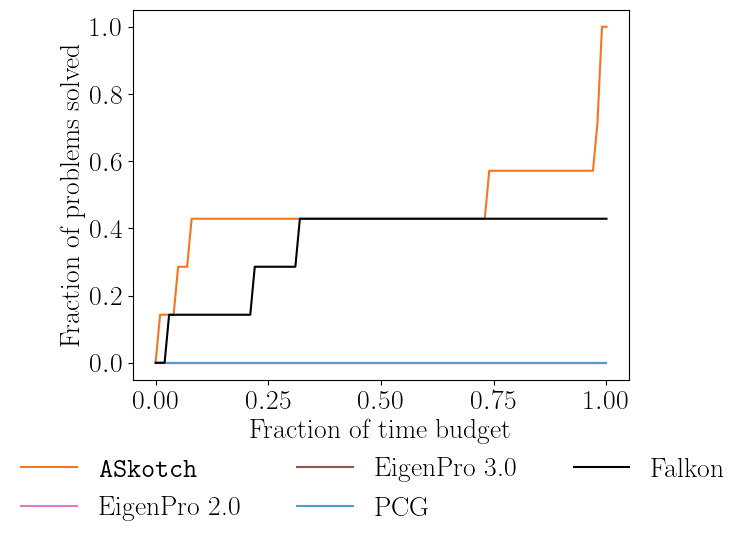

In [14]:
# Make a performance plot for each optimizer based on the best stopping point
fig, ax = plt.subplots()
time_budget = np.linspace(0, 1, 101)

performance = {}

# Loop through the datasets and get performance for each optimizer
for ds, best_stopping_points_ds in best_stopping_points.items():
    for opt, best_stopping_point in best_stopping_points_ds.items():
        relative_stopping_point = best_stopping_point["relative"]
        if opt not in performance:
            performance[opt] = np.zeros_like(time_budget)
        performance[opt] += np.where(time_budget >= relative_stopping_point, 1, 0)

for opt, perf in performance.items():
    ax.plot(time_budget, perf / len(best_stopping_points), label=OPT_LABELS[opt], color=get_color(opt, DUMMY_PLOTTING_RANK))

ax.set_xlabel("Fraction of time budget")
ax.set_ylabel("Fraction of problems solved")
fig.legend(**LEGEND_SPECS)